## Extracting genotype likelihoods and running EBG 

ebg git: https://github.com/pblischak/polyploid-genotyping  

ebg tutorial: https://pblischak.github.io/polyploid-genotyping/

Tiger (genotype error) bitbucket: 
https://bitbucket.org/wegmannlab/tiger/wiki/Home

Tiger paper: https://onlinelibrary.wiley.com/doi/epdf/10.1111/1755-0998.13153  

Workflow thoughts: 

- run UPDOG (https://github.com/dcgerard/updog) to get sequencing error
- use vcfR to extract read depths
- run EBG in various ways: 
    - Correct way for all individuals 
    - Only *tridentata* and *vayesana* as tetraploid, *wyomingensis* as diploid
    - *wyomingensis* as allotetraploid with af for diploid other subspecies
- Also, generate geno. likelihoods for all as diploid. 
- Also also, refilter variants for *tridentata* and *vayesana* separately and treated as diploid

In [28]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [29]:
analysis_dir = '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/'

In [30]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall


In [31]:
!mkdir ebg

mkdir: cannot create directory ‘ebg’: File exists


In [32]:
ebg_dir = os.path.join(analysis_dir, "ebg")
assert os.path.exists(ebg_dir)
ebg_dir

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ebg'

In [33]:
cd $ebg_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ebg


#### Make sure to move vcf file over and make an unziped copy

In [34]:
vcf_gz_file = os.path.join(ebg_dir, "final_snps.recode.vcf.gz")
assert os.path.exists(vcf_gz_file)
vcf_gz_file

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ebg/final_snps.recode.vcf.gz'

## UPDOG 

use updog to calculate sequencing error (R) 
https://github.com/dcgerard/updog

multidog(  
refmat,  
sizemat,  
ploidy,  
model = c("norm", "hw", "bb", "s1", "s1pp", "f1", "f1pp", "flex", "uniform",
"custom"),  
nc = 1,  
p1_id = NULL,  
p2_id = NULL,  
bias_init = exp(c(-1, -0.5, 0, 0.5, 1)),  
prior_vec = NULL,  
...
)


-**refmat:** A matrix of reference read counts. The columns index the individuals and the
rows index the markers (SNPs). This matrix must have rownames (for the names
of the markers) and column names (for the names of the individuals). These
names must match the names in sizemat.  
-**sizemat:** A matrix of total read counts. The columns index the individuals and the rows
index the markers (SNPs). This matrix must have rownames (for the names of
the markers) and column names (for the names of the individuals). These names
must match the names in refmat.  
-**ploidy:** The ploidy of the species. Assumed to be the same for each individual.  
-**model:** What form should the prior (genotype distribution) take? See Details for possible values.  
-**nc:** The number of computing cores to use when doing parallelization on your local
machine. See the section "Parallel Computation" for how to implement more
complicated evaluation strategies using the future package  


In [35]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [36]:
%%R
require(readr)
library(data.table)
library(updog)
require(ggplot2)
library(vcfR)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ebg')

In [37]:
%%R
vcf <- read.vcfR("final_snps.recode.vcf", verbose = FALSE)

#get positions
chrom <- getCHROM(vcf)
pos <- getPOS(vcf)
pos_ID <- paste(chrom,pos,sep = ':')

In [38]:
%%R
#get AD
# ref, alt allele 
ad <- extract.gt(vcf, element = 'AD')

In [39]:
%%R
## check out PL and pos_ID
print(length(pos_ID))
print(pos_ID[1:10])
ad[1:5,1:5]

[1] 17201
 [1] "CM042338.1:1496841" "CM042338.1:1942811" "CM042338.1:6353755"
 [4] "CM042338.1:7214312" "CM042338.1:8063221" "CM042338.1:8177835"
 [7] "CM042338.1:8530959" "CM042338.1:8548932" "CM042338.1:8655617"
[10] "CM042338.1:8690402"
                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841 "0,0"     "1,0"     "3,0"     "6,0"     "8,0"    
CM042338.1_1942811 "0,0"     "0,0"     "0,0"     "0,0"     "9,0"    
CM042338.1_6353755 "6,1"     "3,0"     "3,2"     "4,1"     "4,2"    
CM042338.1_7214312 "5,0"     "3,0"     "0,0"     "0,0"     "0,0"    
CM042338.1_8063221 "0,3"     "0,3"     "0,0"     "0,1"     "8,0"    


In [40]:
%%R
ref_ad <- apply(ad, c(1,2), function(df) as.numeric(unlist(strsplit(as.character(df),','))[1]))
                

In [41]:
%%R
print(dim(ref_ad))
print(ad[1:5,1:5])
print(ref_ad[1:5,1:5])

[1] 17201   690
                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841 "0,0"     "1,0"     "3,0"     "6,0"     "8,0"    
CM042338.1_1942811 "0,0"     "0,0"     "0,0"     "0,0"     "9,0"    
CM042338.1_6353755 "6,1"     "3,0"     "3,2"     "4,1"     "4,2"    
CM042338.1_7214312 "5,0"     "3,0"     "0,0"     "0,0"     "0,0"    
CM042338.1_8063221 "0,3"     "0,3"     "0,0"     "0,1"     "8,0"    
                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841         0         1         3         6         8
CM042338.1_1942811         0         0         0         0         9
CM042338.1_6353755         6         3         3         4         4
CM042338.1_7214312         5         3         0         0         0
CM042338.1_8063221         0         0         0         0         8


In [42]:
%%R
tot_ad <- apply(ad, c(1,2), function(df) sum(as.numeric(unlist(strsplit(as.character(df),',')))))
                

In [43]:
%%R
print(ad[1:5,1:5])
print(dim(tot_ad))
print(ad[1:5,1:5])
print(ref_ad[1:5,1:5])
print(tot_ad[1:5,1:5])

                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841 "0,0"     "1,0"     "3,0"     "6,0"     "8,0"    
CM042338.1_1942811 "0,0"     "0,0"     "0,0"     "0,0"     "9,0"    
CM042338.1_6353755 "6,1"     "3,0"     "3,2"     "4,1"     "4,2"    
CM042338.1_7214312 "5,0"     "3,0"     "0,0"     "0,0"     "0,0"    
CM042338.1_8063221 "0,3"     "0,3"     "0,0"     "0,1"     "8,0"    
[1] 17201   690
                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841 "0,0"     "1,0"     "3,0"     "6,0"     "8,0"    
CM042338.1_1942811 "0,0"     "0,0"     "0,0"     "0,0"     "9,0"    
CM042338.1_6353755 "6,1"     "3,0"     "3,2"     "4,1"     "4,2"    
CM042338.1_7214312 "5,0"     "3,0"     "0,0"     "0,0"     "0,0"    
CM042338.1_8063221 "0,3"     "0,3"     "0,0"     "0,1"     "8,0"    
                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841         0         1         3         6         8
CM042338.1_1942811

In [44]:
%%R
# turn ref_ad numeric 
ref_ad <- apply(ref_ad, c(1,2), function(df) as.numeric(df))

In [45]:
%%R
fwrite(tot_ad,'tot_ad.txt',quote=FALSE)
fwrite(ref_ad,'ref_ad.txt',quote=FALSE)

R[write to console]: x being coerced from class: matrix to data.table

R[write to console]: x being coerced from class: matrix to data.table



In [46]:
%%R
#split file to include only tetraploids
indv <- colnames(ad)

Sp <- rep(NA,times=length(indv))
Ploidy <- rep(NA,times=length(indv))
Pop <- rep(NA,times=length(indv))
ID <- rep(NA,times=length(indv))
All <- rep(NA,times=length(indv))
for (i in 1:length(indv)){
  SpP <- unlist(strsplit(as.character(indv[i]),"_"))[1]
  Sp[i] <- gsub('\\d','',SpP,perl=TRUE)
  Ploidy[i] <-  gsub('(\\D)','',SpP,perl=TRUE)
  Pop[i] <- unlist(strsplit(as.character(indv[i]),"_"))[2]
  ID[i] <- unlist(strsplit(as.character(indv[i]),"_"))[3]
  All[i] <- as.character(indv[i])
}
Pop_ID <- data.frame(Sp=Sp,Ploidy=Ploidy,Pop=Pop,ID=ID,All=All,
                     SpPloidy=paste0(Sp,Ploidy))
write.csv(Pop_ID,'Pop_ID.csv',row.names=FALSE)

In [47]:
%%R
head(Pop_ID)

  Sp Ploidy Pop ID       All SpPloidy
1 AT      2  BB 10 AT2_BB_10      AT2
2 AT      2  BB 11 AT2_BB_11      AT2
3 AT      2  BB 12 AT2_BB_12      AT2
4 AT      2  BB 13 AT2_BB_13      AT2
5 AT      2  BB 14 AT2_BB_14      AT2
6 AT      2  BB 15 AT2_BB_15      AT2


In [48]:
%%R

ploidy_index <- which(Pop_ID$Ploidy == 4)
tot_ad_4 <- tot_ad[,ploidy_index]
ref_ad_4 <- ref_ad[,ploidy_index]

print(length(ploidy_index))
print(dim(tot_ad_4))
print(dim(ref_ad_4))

[1] 291
[1] 17201   291
[1] 17201   291


#### Run updog 

In [49]:
%%R 
updog_out <- multidog(refmat=ref_ad_4,
                      sizemat=tot_ad_4,
                      ploidy=4,
                      model = "hw",
                      nc = 32)

saveRDS(updog_out,'updog_out.RDS')

    |                                   *.#,%    
   |||                                 *******/  
 |||||||    (**..#**.                  */   **/  
|||||||||    */****************************/*%   
   |||    &****..,*.************************/    
   |||     (....,,,*,...****%********/(******    
   |||                ,,****%////,,,,./.****/    
   |||                  /**//         .*///....  
   |||                  .*/*/%#         .,/   ., 
   |||               , **/   #%         .*    .. 
   |||                               ,,,*        

Working on it...done!

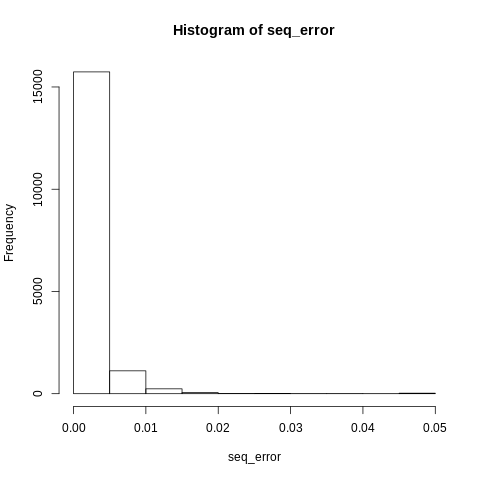

In [52]:
%%R
seq_error <- updog_out$snpdf$seq
hist(seq_error)

In [53]:
%%R
#length(seq_error)
str(updog_out)
#which(pos_ID != updog_out$snpdf$snp)

List of 2
 $ snpdf:'data.frame':	17201 obs. of  19 variables:
  ..$ snp     : Factor w/ 17201 levels "CM042338.1_1496841",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ bias    : num [1:17201] 0.797 0.443 0.561 0.893 0.532 ...
  ..$ seq     : num [1:17201] 0.00147 0.00288 0.01976 0.00245 0.0041 ...
  ..$ od      : num [1:17201] 0.0032 0.00326 0.0031 0.00321 0.00331 ...
  ..$ prop_mis: num [1:17201] 0.0262 0.4944 0.4868 0.0586 0.4941 ...
  ..$ num_iter: num [1:17201] 13 123 190 6 173 14 10 5 19 7 ...
  ..$ llike   : num [1:17201] -18.4 -219.3 -381.4 -67.8 -289 ...
  ..$ ploidy  : num [1:17201] 4 4 4 4 4 4 4 4 4 4 ...
  ..$ model   : Factor w/ 1 level "hw": 1 1 1 1 1 1 1 1 1 1 ...
  ..$ p1ref   : num [1:17201] NA NA NA NA NA NA NA NA NA NA ...
  ..$ p1size  : num [1:17201] NA NA NA NA NA NA NA NA NA NA ...
  ..$ p2ref   : num [1:17201] NA NA NA NA NA NA NA NA NA NA ...
  ..$ p2size  : num [1:17201] NA NA NA NA NA NA NA NA NA NA ...
  ..$ Pr_0    : num [1:17201] 1.18e-08 6.27e-03 4.10e-02 4.78e-07 1.

In [54]:
%%R
updog_snp <- updog_out$snpdf$snp
updog_snp <- sapply(updog_snp, function(s) gsub('_',':',s))

In [55]:
%%R
print(length(updog_snp))
print(length(pos_ID))

[1] 17201
[1] 17201


In [56]:
%%R
seq_err_df <- data.frame(error=round(seq_error,5))
write.table(seq_err_df,'seq_error.txt',row.names=FALSE,col.names=FALSE)

## EBG 

https://pblischak.github.io/polyploid-genotyping/

**Input data formats:**  
There are three input files that are necessary to run an analysis with ebg (four if you are using the alloSNP model). The read count data files (total and alternative allele read counts) should be in plain text files as tab delimited matrices with individuals as rows and loci as columns. The per locus error rates files should be a single column with the error value listed for each locus on one line.  
  
Reference allele frequencies (**alloSNP** model only)  
If you are running the *alloSNP* model, you will need a reference panel of allele frequencies for the genotypes in subgenomes one. This should be formated in the same way as the per locus error rates file: one allele frequency per locus listed on separate lines.  
  
**Running analyses:**  
Analyses for each model can be run from the command line by calling the ebg executable. The options for each of the models can be viewed by typing: ebg model -h. Below we have given an example of what should be typed at the command line to run each model.  
  
**hwe**  
ebg hwe -t tot-reads.txt \  
        -a alt-reads.txt \  
        -e error.txt \  
        -p 4 \  
        --iters 1000 \  
        --prefix hwe-test   
**diseq**  
ebg diseq -t tot-reads.txt \  
          -a alt-reads.txt \  
          -e error.txt \  
          -p 4 \  
          --iters 1000 \  
          --prefix diseq-test  
          
          
**alloSNP**  
ebg alloSNP -f reference-freqs.txt \  
            -t tot-reads.txt \  
            -a alt-reads.txt \  
            -e error.txt \  
            -p1 2 \  
            -p2 4 \  
            --iters 1000 \  
            --prefix alloSNP-test  
            
              --stop              <double>     Stop value for ECM algorithm parameter updates (default = 1e-5)
            
**notes**   
    - EM iterations so 1000 is just the limit  
    
    
**Ways we want to run**  
    - hwe preformed poorly so just diseq and alloSNP  
    - diseq just run all tetraploids as auto  
    - allosnp: run just wyomingensis with tridentata and vayesana diploid allele freqs  
        - need to wait for entropy to get allele freqs for AT and AV before running allosnp
        
        **REMOVE CM042346.1:131497851, 40397**
        
     

In [57]:
cd $ebg_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ebg


#### Make input files 

In [58]:
%%R
Pop_ID <- read.csv('Pop_ID.csv')
tot_ad <- data.frame(fread('tot_ad.txt'))
ref_ad <- data.frame(fread('ref_ad.txt'))

In [59]:
%%R 
# need alternate allele too 
alt_ad <- apply(ad, c(1,2), function(df) as.numeric(unlist(strsplit(as.character(df),','))[2]))


In [60]:
%%R
print(ad[1:5,1:5])
print(dim(alt_ad))
print(alt_ad[1:5,1:5])

                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841 "0,0"     "1,0"     "3,0"     "6,0"     "8,0"    
CM042338.1_1942811 "0,0"     "0,0"     "0,0"     "0,0"     "9,0"    
CM042338.1_6353755 "6,1"     "3,0"     "3,2"     "4,1"     "4,2"    
CM042338.1_7214312 "5,0"     "3,0"     "0,0"     "0,0"     "0,0"    
CM042338.1_8063221 "0,3"     "0,3"     "0,0"     "0,1"     "8,0"    
[1] 17201   690
                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841         0         0         0         0         0
CM042338.1_1942811         0         0         0         0         0
CM042338.1_6353755         1         0         2         1         2
CM042338.1_7214312         0         0         0         0         0
CM042338.1_8063221         3         3         0         1         0


In [63]:
%%R
fwrite(alt_ad,'alt_ad.txt',quote=FALSE)

R[write to console]: x being coerced from class: matrix to data.table



In [64]:
%%R
ploidy_index <- which(Pop_ID$Ploidy == 4)
tot_ad_4 <- tot_ad[,ploidy_index]
ref_ad_4 <- ref_ad[,ploidy_index]
alt_ad_4 <- alt_ad[,ploidy_index]
Pop_ID_4 <- Pop_ID[ploidy_index,]

print(length(ploidy_index))
print(dim(tot_ad_4))
print(dim(ref_ad_4))
print(dim(alt_ad_4))

[1] 291
[1] 17201   291
[1] 17201   291
[1] 17201   291


In [65]:
%%R
write.csv(Pop_ID_4,'Pop_ID_4.csv',row.names=FALSE)
fwrite(t(tot_ad_4),'tot_ad_4.txt',sep='\t',row.names=FALSE,col.names=FALSE)
fwrite(t(ref_ad_4),'ref_ad_4.txt',sep='\t',row.names=FALSE,col.names=FALSE)
fwrite(t(alt_ad_4),'alt_ad_4.txt',sep='\t',row.names=FALSE,col.names=FALSE)

R[write to console]: x being coerced from class: matrix to data.table

R[write to console]: x being coerced from class: matrix to data.table

R[write to console]: x being coerced from class: matrix to data.table



In [66]:
### select options for slurm submission
#account = 'cpu-s1-bionres-0'
#partition = 'cpu-s1-bionres-0'
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '10-00:00:00' #time limit 1 day
cpus = 1
mem_cpu = 36000
email = 'tfaske@nevada.unr.edu'

### ebg inputs
ebg = '/data/gpfs/assoc/parchmanlab/tfaske/src/polyploid-genotyping/ebg/./ebg'
nindv = 291
nloci = 17201
iters = 2000
stop = '1e-4'
tot_file = 'tot_ad_4.txt'
alt_file = 'alt_ad_4.txt'
error_file = 'seq_error.txt'
out_file = 'ARTR.diseq.all'

In [67]:
def write_ebg_diseq_sh(account,partition,time,cpus,mem_cpu,email,ebg,nindv,nloci,tot_file,alt_file,error_file,iters,stop,out_file):
    with open("run_ebg_diseq.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ebg_diseq
#SBATCH --output output_ebg_diseq.txt
#SBATCH --mail-type=FAIL,END
#SBATCH --mail-user=%s \n

%s diseq -n %s -l %s -t %s -a %s -e %s -p 4 --iters %s --stop %s --prefix %s \n""" % 
                (account,partition,time,int(cpus),int(mem_cpu),email,ebg,nindv,nloci,tot_file,alt_file,error_file,iters,stop,out_file))
        

In [68]:
write_ebg_diseq_sh(account,partition,time,cpus,mem_cpu,email,ebg,nindv,nloci,tot_file,alt_file,error_file,iters,stop,out_file)

## Run ebg with only AT4 and AV4

Assumming allotetraploid for AW4

In [247]:
cd $ebg_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ebg


#### Make input files 

In [248]:
%%R
Pop_ID <- read.csv('Pop_ID.csv')
tot_ad <- data.frame(fread('tot_ad.txt'))
alt_ad <- data.frame(fread('alt_ad.txt'))

In [249]:
%%R
print(ad[1:5,1:5])
print(dim(ad))
print(tot_ad[1:5,1:5])
print(alt_ad[1:5,1:5])

                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_398150  "1,0"     "0,0"     "0,0"     "0,0"     "2,0"    
CM042338.1_1342981 "0,0"     "0,0"     "0,0"     "0,0"     "4,0"    
CM042338.1_1496841 "0,0"     "1,0"     "3,0"     "6,0"     "8,0"    
CM042338.1_1744262 "8,0"     "1,0"     "0,0"     "0,0"     "4,0"    
CM042338.1_1942811 "0,0"     "0,0"     "0,0"     "0,0"     "9,0"    
[1] 42513   684
  AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
1         1         0         0         0         2
2         0         0         0         0         4
3         0         1         3         6         8
4         8         1         0         0         4
5         0         0         0         0         9
  AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
1         0         0         0         0         0
2         0         0         0         0         0
3         0         0         0         0         0
4         0         0         0         0         

In [250]:
%%R 
head(Pop_ID)

  Sp Ploidy Pop ID       All SpPloidy
1 AT      2  BB 10 AT2_BB_10      AT2
2 AT      2  BB 11 AT2_BB_11      AT2
3 AT      2  BB 12 AT2_BB_12      AT2
4 AT      2  BB 13 AT2_BB_13      AT2
5 AT      2  BB 14 AT2_BB_14      AT2
6 AT      2  BB 15 AT2_BB_15      AT2


In [252]:
%%R
ATAV_index <- which(Pop_ID$SpPloidy %in% c('AT4','AV4'))
tot_ad_minusAW <- tot_ad[,ATAV_index]
alt_ad_minusAW <- alt_ad[,ATAV_index]
Pop_ID_minusAW <- Pop_ID[ATAV_index,]

print(length(ATAV_index))
print(dim(tot_ad_minusAW))
print(dim(alt_ad_minusAW))

[1] 98
[1] 42513    98
[1] 42513    98


In [253]:
%%R
write.csv(Pop_ID_minusAW,'Pop_ID_minusAW.csv',row.names=FALSE)
fwrite(t(tot_ad_minusAW[-40397,]),'tot_ad_minusAW.txt',sep='\t',row.names=FALSE,col.names=FALSE)
fwrite(t(alt_ad_minusAW[-40397,]),'alt_ad_minusAW.txt',sep='\t',row.names=FALSE,col.names=FALSE)

In [257]:
### select options for slurm submission
#account = 'cpu-s1-bionres-0'
#partition = 'cpu-s1-bionres-0'
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '10-00:00:00' #time limit 1 day
cpus = 1
mem_cpu = 36000
email = 'tfaske@nevada.unr.edu'

### ebg inputs
ebg = '/data/gpfs/assoc/parchmanlab/tfaske/src/polyploid-genotyping/ebg/./ebg'
nindv = 98
nloci = 42512
iters = 2000
stop = '1e-3'
tot_file = 'tot_ad_minusAW.txt'
alt_file = 'alt_ad_minusAW.txt'
error_file = 'seq_error.txt'
out_file = 'ARTR.diseq.minusAW'

In [258]:
def write_ebg_diseq_minusAW_sh(account,partition,time,cpus,mem_cpu,email,ebg,nindv,nloci,tot_file,alt_file,error_file,iters,stop,out_file):
    with open("run_ebg_diseq_minusAW.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ebg_diseq_minusAW
#SBATCH --output output_ebg_diseq_minusAW.txt
#SBATCH --mail-type=FAIL,END
#SBATCH --mail-user=%s \n

%s diseq -n %s -l %s -t %s -a %s -e %s -p 4 --iters %s --stop %s --prefix %s \n""" % 
                (account,partition,time,int(cpus),int(mem_cpu),email,ebg,nindv,nloci,tot_file,alt_file,error_file,iters,stop,out_file))
        

In [259]:
write_ebg_diseq_minusAW_sh(account,partition,time,cpus,mem_cpu,email,ebg,nindv,nloci,tot_file,alt_file,error_file,iters,stop,out_file)

# OLDDDD, no tiger

## Tiger

./tiger task=estimateHardyWeinberg vcf=simple.vcf.gz groups=simple_sampleGroups.txt

sample groups will be ssp and ploidy (5 total groups)
- file setup: sample name and group (must have header)

Notes: 
 - mcmc takes forever. Reduce burnin rounds and samples 
     - OR: EM ML only? 
     - Ran EM ML only and doesnt give per locus error rates. Need to run MCMC

**Inference algorithm**

For all models you can choose if you want to infer the parameters with an EM-algorithm and obtain the maximum likelihood estimates or if you want to use an MCMC and obtain the posterior densities of the parameters. The parameter for this is algo and you can set it to either MLE or Bayes.

**Parameters:**

- **algo:** Can be set to either "MLE" or "Bayes". Default for the Hardy-Weinberg model is Bayes and for the rest MLE.
- **numIter:** Control the maximum number of iterations of the EM algorithm or MCMC algorithm. Default for EM = 1000 default for MCMC = 100000.
- **minDelta:** Assume EM-algorithm to have converged when the parameter value does not change by more than minDelta. default = 0.000001
- **minEpsIter:** Minimum amount of EM iterations to be run, even if algorithm has converged
- **maxEpsIter:** Minimum amount of EM iterations to be run, even if algorithm has not converged
- **burnin:** Length of burnin in MCMC. Default = 5000
- **numBurnins:** Number of burnin rounds in MCMC (used to adjust proposal range for optimal acceptance rate). Default = 5
- **thinning:** After how many MCMC iterations the sampled values should be printed to file. Default = 10.
- **epsLambda:** The parameter used for the exponential prior on the error rates

In [90]:
!zcat $vcf_gz_file | bcftools query -l | sort > sampleGroups.txt 


gzip: stdout: Broken pipe


In [91]:
sample_group = pd.read_csv('sampleGroups.txt',header=None,names=['sample'])

In [92]:
sample_group.head()

,sample
0,AT2_BB_1
1,AT2_BB_10
2,AT2_BB_11
3,AT2_BB_12
4,AT2_BB_13


In [93]:
ssp_ploidy = sample_group['sample'].str.split('_',expand=True)[0]
ssp_ploidy

0      AT2
1      AT2
2      AT2
3      AT2
4      AT2
      ... 
679    AW4
680    AW4
681    AW4
682    AW4
683    AW4
Name: 0, Length: 684, dtype: object

In [94]:
ssp_ploidy_num = ssp_ploidy.replace(ssp_ploidy.unique(),range(1,(len(ssp_ploidy.unique())+1)))

In [95]:
ssp_ploidy_num

0      1
1      1
2      1
3      1
4      1
      ..
679    5
680    5
681    5
682    5
683    5
Name: 0, Length: 684, dtype: int64

In [96]:
sample_group['group'] = ssp_ploidy_num

In [97]:
sample_group.to_csv('sampleGroups.txt',sep='\t',index=False)

In [98]:
!head sampleGroups.txt

sample	group
AT2_BB_1	1
AT2_BB_10	1
AT2_BB_11	1
AT2_BB_12	1
AT2_BB_13	1
AT2_BB_14	1
AT2_BB_15	1
AT2_BB_16	1
AT2_BB_17	1


### Make slurm file to run tiger

In [108]:
tiger = '/data/gpfs/assoc/parchmanlab/tfaske/src/Tiger/./tiger'

In [109]:
### select options for slurm submission
#account = 'cpu-s1-bionres-0'
#partition = 'cpu-s1-bionres-0'
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '4-00:00:00' #time limit 1 day
cpus = 2
mem_cpu = 16000
email = 'tfaske@nevada.unr.edu'

### because need to edit!!!
vcf_gz_file = 'good_snps.edit.vcf.gz'

#### model parameters for MLE
#algo = "MLE"
#numIter = 501
#maxEpsIter = 500

#sbatch cmd
#%s task=estimateHardyWeinberg vcf=%s groups=sampleGroups.txt outname=ARTR.tiger.hwe algo=%s numIter=%s maxEpsIter=%s\n""" % 

#### model parameters for MCMC
# below gives 2500 samples 
algo = "Bayes"
numIter = 30000
burnin = 2500
numBurnins = 2 
thinning = 10

#sbatch cmd
#%s task=estimateHardyWeinberg vcf=%s groups=sampleGroups.txt outname=ARTR.tiger.hwe algo=%s numIter=%s burnin=%s numBurnins=%s thinning=%s\n""" % 



In [110]:
def write_tiger_sh(account,partition,time,cpus,mem_cpu,email,tiger,vcf,algo,numIter,burnin,numBurnins,thinning):
    with open("run_tiger.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name tiger
#SBATCH --output output_tiger.txt
#SBATCH --mail-type=FAIL,END
#SBATCH --mail-user=%s \n

module load gcc/9.2.0\n
%s task=estimateHardyWeinberg vcf=%s groups=sampleGroups.txt outname=ARTR.tiger.hwe algo=%s numIter=%s burnin=%s numBurnins=%s thinning=%s\n""" % 
                (account,partition,time,int(cpus),int(mem_cpu),email,tiger,vcf,algo,numIter,burnin,numBurnins,thinning))
        

In [111]:
write_tiger_sh(account,partition,time,cpus,mem_cpu,email,tiger,vcf_gz_file,algo,numIter,burnin,numBurnins,thinning)

#### errors 

ERROR: Error when parsing vcf header, unknown tag 'Version' in l
ine '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Dis
tance Bias for filtering splice-site artefacts in RNA-seq data (
bigger is better)",Version="3">'!

solution: grep -v ',Version="3"' good_snps.recode.vcf > good_snps.edit.vcf; bgzip good_snps.edit.vcf